# 04. PyTorch Custom Datasets

Course video - [Source](https://www.youtube.com/watch?v=Z_ikDlimN6A)

GitHub Repo - [Source](https://github.com/Yer-Marti/PyTorch-Course)

PyTorch Doc - [Source](https://pytorch.org/docs/stable/index.html)

## Contents

* [Theory](#scrollTo=AVCroFXhB1hq&line=1&uniqifier=1)
* [0. Importing PyTorch and setting up device-agnostic code](#scrollTo=YMDJeRibESFz)
* [1. Get data](#scrollTo=HhIwpuZCOei2)
* [2. Data preparation and data exploration](#scrollTo=FQ7AH_CaTNMT)
* [3. Transforming data](#scrollTo=0mCQHTdYapaZ)
* [4. Option 1: Loading image data using `ImageFolder`](#scrollTo=BBFLxgsJHpNk)
* [5. Option 2: Loading image data using a custom `Dataset`](#scrollTo=zN-QTUEdPPsZ)
* [6. Other forms of transforms (data augmentation)](#scrollTo=ts6iMo_KbD0i)
* [7. Model 0: TinyVGG without data augmentation](#scrollTo=nnJJFgZpgIaR)
* [8. What should an ideal loss curve look like?](#scrollTo=QnWOluu0cvAA&line=1&uniqifier=1)
* [9. Model 1: TinyVGG with data augmentation](#scrollTo=NPgtk48mkC1G&line=1&uniqifier=1)
* [10. Compare model results](#scrollTo=AvN2LTjWsoPb&line=1&uniqifier=1)
* [11. Making a prediction on a custom image](#scrollTo=TebNxai_7BAi&line=1&uniqifier=1)
* [Exercises](#scrollTo=Ky1FQbhlJy2x&line=1&uniqifier=1)

## Theory

PyTorch has libraries for many fields:
* `torchvision` for computer vision.
* `torchtext` for natural language.
* `torchaudio` for audio and signal processing.
* `TorchRec` for recommender systems.

In the previous section, we used some built-in datasets with PyTorch, so now, we are going to use our own datasets.

## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

device, torch.__version__

('cuda', '2.2.1+cu121')

## 1. Get data

Our dataset is a subset of the Food101 dataset.

Food101 states 101 different classes of food, with 1000 images per class (750 training, 250 testing).

Our dataset will consist of only 3 classes with only 10% of the original (75, 25).

When starting a Machine Learning project, it's important to start small and then scale when everything is working fine.

In [2]:
import requests
import zipfile
from pathlib import Path

# Set up path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the folder doesn't exist, create it
if image_path.is_dir():
  print(f"{image_path} already exists")
else:
  print(f"Creating {image_path}...")
  image_path.mkdir(parents=True, exist_ok=True)

# Dowload
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print(f"Downloading data...")
  f.write(request.content)

# Unzip data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping data...")
  zip_ref.extractall(image_path)

Creating data/pizza_steak_sushi...
Unzipping data...


> **Note:** we need to download the *raw* file, else we are going to get an error. When copying the link, change `/blob/` to `/raw/`.

## 2. Data preparation and data exploration

In [3]:
import os

def walk_though_dir(dir_path):
  """Walks though dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

In [4]:
walk_though_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'


In [5]:
# Set up train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

>The convention for storing datasets is as follows:
>
>```
dataset-name/ # <-- dataset folder
  train/ # <-- training images
    class-1/ <-- class name as folder name
      data-01
      data-02
      ...
    class-2/
      data-10
      data-11
      ...
  test/ # <-- testing images
    class-1/
      data-100
      data-101
      ...
    class-2/
      data-110
      data-111
      ...
```

Now let's write code to:
1. Get all of the image paths
2. Pick a random image using Python's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we are working with images, let's open the image with Python's [PIL](https://pypi.org/project/pillow/)
5. We'll then show the image and print metadata

Random image path: data/pizza_steak_sushi/test/sushi/207578.jpg
Image class: sushi
Image height: 512
Image width: 382


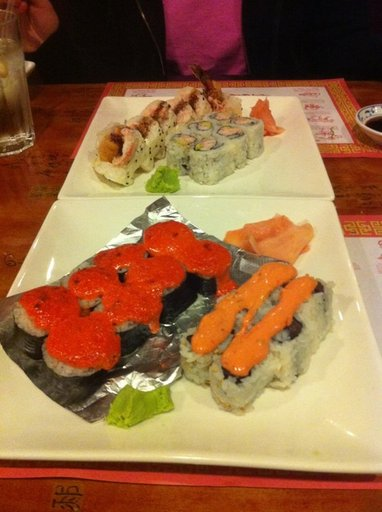

In [6]:
import random
from PIL import Image

random.seed(42)

# 1
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2
random_image_path = random.choice(image_path_list)

# 3
image_class = random_image_path.parent.stem

# 4
img = Image.open(random_image_path)

# 5
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

Visualizing it with `matplotlib`:

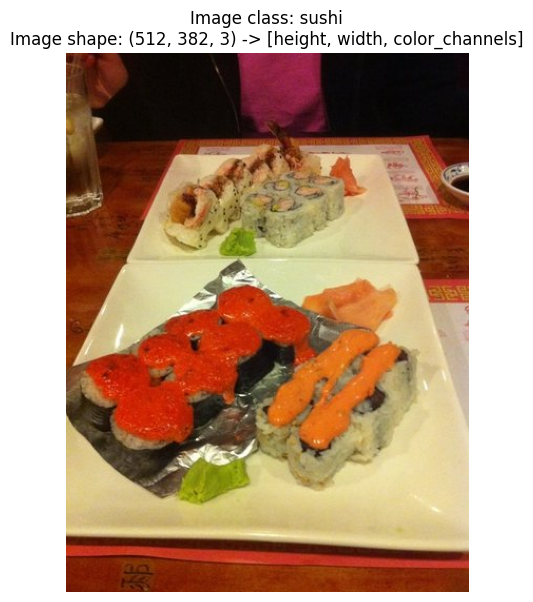

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Turn image into an array
img_as_array = np.asarray(img)

# Plot img
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.axis(False)
plt.title(f"Image class: {image_class}\nImage shape: {img_as_array.shape} -> [height, width, color_channels]");

## 3. Transforming data

Before we can use our image data with PyTorch we have to:
1. Turn target data into tensors.
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`.

In [8]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

In [9]:
# Write transforms for image
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal (p <- probability of happening)
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a tensor
    transforms.ToTensor()
])

In [10]:
_ = data_transform(img)
_.shape, _.dtype

(torch.Size([3, 64, 64]), torch.float32)

### 3.2 Visualizating the transformed images

We can visualize the transformed image, so it's more understandable.

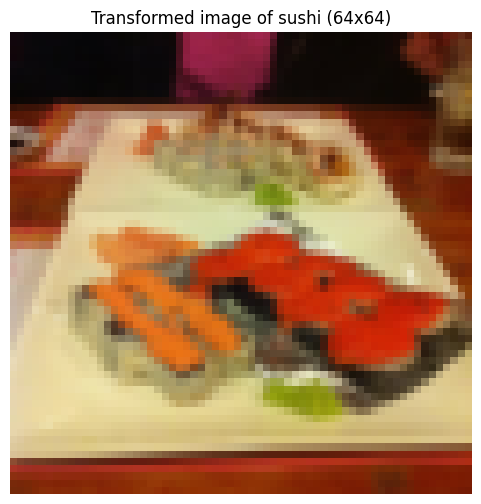

In [11]:
plt.figure(figsize=(6, 6))
plt.title(f"Transformed image of {image_class} (64x64)")
plt.axis(False)
plt.imshow(_.permute([1, 2, 0]));

> **Note:** the correct function to use here is `permute()`, which serves as transposing a matrix without moving the data from one place to another (more or less). Using `reshape()` or `view()` gives a totally different result that we are not looking for in this case.

Now, we can make a function that plots how it changes our images:

In [12]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
  """
  Selects random images from a path of images and loads/transforms them and compares them to the original
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      transformed_image = transform(f)
      transformed_image = transformed_image.permute([1, 2, 0])
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

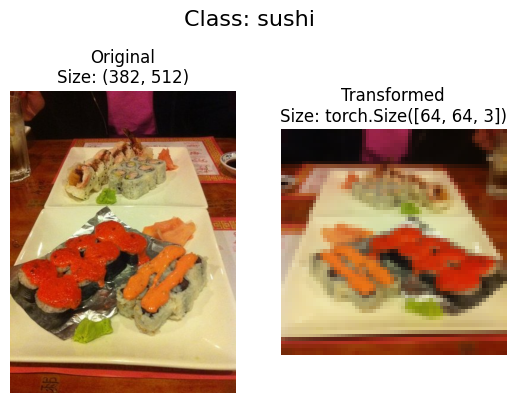

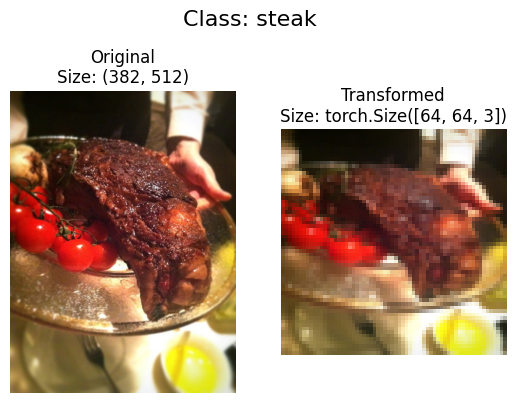

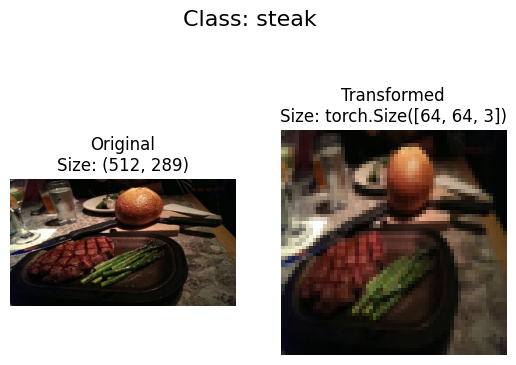

In [13]:
plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)

## 4. Option 1: Loading image data using `ImageFolder`

Our first option to load data into a dataset is using a pre-built function. In this case, because we are working with images, we are using `torchvision.datasets.ImageFolder`.

In [14]:
# Use ImageFolder to create the dataset
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the features/data
                                  target_transform=None) # a transform for the targets/labels

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

A benefit to using `ImageFolder` is that comes with some defined attributes we can use:

In [15]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [16]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [17]:
# Check lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [18]:
# Check first train sample
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [19]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor: {img.shape}\nImage datatype: {img.dtype}\nImage class: {class_names[label]}\nImage label: {label}\nImage label type: {type(label)}")

Image tensor: torch.Size([3, 64, 64])
Image datatype: torch.float32
Image class: pizza
Image label: 0
Image label type: <class 'int'>


### 4.1 Turn loaded datasets into dataloaders

In [20]:
from torch.utils.data import DataLoader

BATCH_SIZE = 1

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1, # defines how many cores are used to load the data
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x77fb89226110>,
 <torch.utils.data.dataloader.DataLoader at 0x77fb89226650>)

> **Note:** we can get how many cores we have with the following code.

In [21]:
import os
os.cpu_count()

2

In [22]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [23]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 5. Option 2: Loading image data using a custom Dataset

Things we need to be able to do:
1. Load images from file
2. Get class names from the Dataset
3. Get classes as a dictionary from the Dataset

Pros:
* Can create a `Dataset` out of almost anything.
* Not limited to PyTorch pre-built `Dataset` functions.

Cons:
* Even though you can create almost anything, it doesn't mean it will work.
* Often results in us writing more code, which means more possible errors or performance issues.

> **Note:** Custom datasets in PyTorch often subclass `torch.utils.data.Dataset`.

In [24]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

### 5.1 Creating a helper function to get class names

We want the function to:
1. Get the class names using `os.scandir()` to traverse a target directory
2. Raise an error if the class names are not found (if something is wrong with the structure)
3. Turn the class names into a dict and a list and return them

In [25]:
# Set up path for target dir
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target dir
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

> **Note:** line 6 is a *list comprehension*.

Turning it into a function.

In [26]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in a target directory."""
  classes = sorted([entry.name for entry in os.scandir(directory) if entry.is_dir()])

  if not classes:
    raise FileNotFoundError(f"Could not find any classes in {directory}.")

  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

  return classes, class_to_idx

> **Note:** line 8 is a *dictionary comprehension*.

In [27]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

Things we need to account for:
* Subclass `torch.utils.data.Dataset`
* Init our subclass with a target directory and a transform for our data
* Create attributes:
  * paths - paths of our images
  * transform - the transform to use
  * classes - a list of the  target classes
  * classes_to_idx - a dict of the target classes mapped to integer labels
* Create `load_image()` method to open an image
* Overwrite `__getitem__()` method to return a given sample when given an index
* Overwrite `__len__()` method to return the length of our dataset

> **Doc:** see [`torch.utils.data`](https://pytorch.org/docs/stable/data.html).

In [28]:
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
  def __init__(self,
               targ_dir: str,
               transform=None):

    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))

    self.transform = transform

    self.classes, self.class_to_idx = find_classes(targ_dir)

  def load_image(self, index: int) -> Image.Image:
    image_path = self.paths[index]
    return Image.open(image_path)

  def __len__(self) -> int:
    return len(self.paths)

  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx

In [29]:
# Create a transform
train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [30]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x77fb89227a60>,
 <__main__.ImageFolderCustom at 0x77fb89227d00>)

In [31]:
print("Train:")
print(f"\tNormal len: {len(train_data)} | Custom len: {len(train_data_custom)}")
print("Test:")
print(f"\tNormal len: {len(test_data)} | Custom len: {len(test_data_custom)}")

Train:
	Normal len: 225 | Custom len: 225
Test:
	Normal len: 75 | Custom len: 75


In [32]:
train_data.classes, train_data_custom.classes

(['pizza', 'steak', 'sushi'], ['pizza', 'steak', 'sushi'])

In [33]:
train_data.class_to_idx, train_data_custom.class_to_idx

({'pizza': 0, 'steak': 1, 'sushi': 2}, {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.3 Create a function to display random images

1. Take in a `Dataset` and other parameters needed.
2. To prevent the display getting out of hand, let's cap the number of images to display at 10.
3. Set the random seed for reproducibility.
4. Get a list of random sample indexes from the target dataset.
5. Set up a `matplotlib` plot.
6. Look through the random sample images and plot them, making sure that the dimensions align to HWC.

In [34]:
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  if n > 10:
    n = 10
    display_shape = False

  if seed:
    random.seed(seed)

  random_samples_idx = random.sample(range(len(dataset)), k=n)

  plt.figure(figsize=(16, 8))

  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    targ_image_adjust = targ_image.permute([1, 2, 0])

    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title += f"\nShape: {targ_image_adjust.shape}"
    plt.title(title)

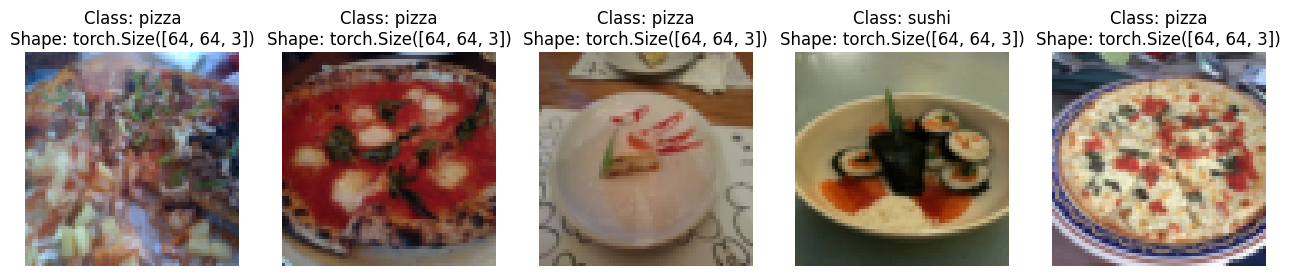

In [35]:
display_random_images(
    train_data,
    n=5,
    classes=class_names,
    seed=None
)

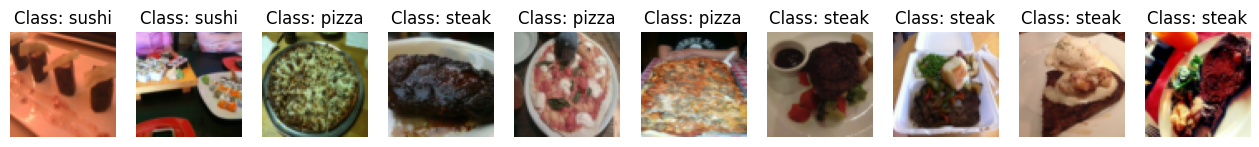

In [36]:
display_random_images(
    train_data_custom,
    n=20,
    classes=class_names,
    seed=None
)

### 5.4 Turn custom loaded images into `DataLoader`'s

In [37]:
from torch.utils.data import DataLoader

BATCH_SIZE = 1
NUM_WORKERS = os.cpu_count()

train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x77fb88ff8970>,
 <torch.utils.data.dataloader.DataLoader at 0x77fb88ffa410>)

In [38]:
# Get image and label from dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

img_custom.shape, label_custom.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

## 6. Other forms of transforms (data augmentation)

Data augmentation is the process of artificially adding diversity to our training data to prevent overfitting.

For starters, let's go with [TrivialAugment](https://pytorch.org/vision/main/generated/torchvision.transforms.TrivialAugmentWide.html).

In [39]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [40]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

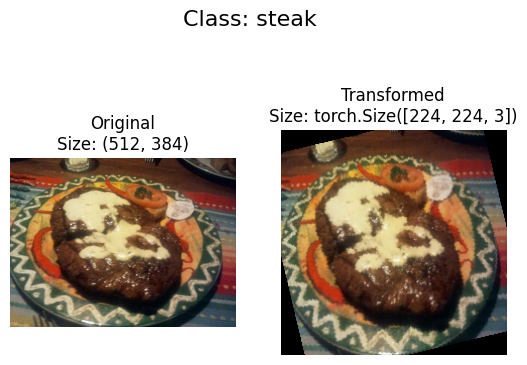

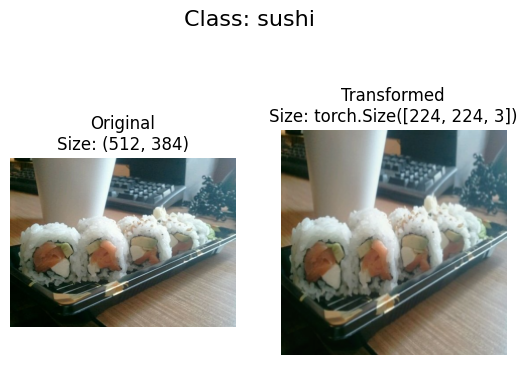

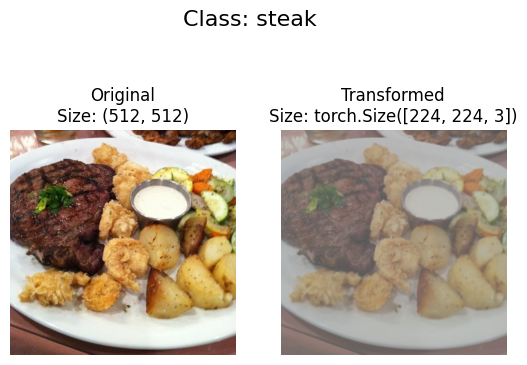

In [41]:
# Plot random transformed images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

## 7. Model 0: TinyVGG without data augmentation

We are going to replicate the same architecture as in the previous lesson, the one used in the [CNN Explainer](https://poloclub.github.io/cnn-explainer/).

### 7.1 Creating transforms and load data for Model 0

In [42]:
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [43]:
from torchvision import datasets

train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

In [44]:
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=False,
                                     num_workers=NUM_WORKERS)

### 7.2 Creating the architecture

In [45]:
from torch import nn

class TinyVGG(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel_size
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel_size
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self, x):
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [46]:
torch.manual_seed(42)

model_0 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(class_names)
).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass in the model

Let's pass dummy data to check the input of the classifier layer.

In [47]:
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [48]:
# Try forward pass
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4669e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9129e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6417e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7980e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1815e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3994e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.2317e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### 7.4 Use `torchinfo` to show info about the model

In [49]:
# Use Torchinfo to show model summary
try:
  from torchinfo import summary
except:
  print("Installing torchinfo...")
  !pip install torchinfo
  from torchinfo import summary

Installing torchinfo...


In [50]:
summary(model_0, input_size=(BATCH_SIZE, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

> **Note:** we can actually use this to check the model without needing dummy data.

### 7.5 Create train and test functions

In [51]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device="cpu"):
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to the target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X) # output model logits

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  return train_loss, train_acc

In [52]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device="cpu"):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0,  0

  # Turn on inference mode
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss /= len(dataloader)
  test_acc /= len(dataloader)
  return test_loss, test_acc

### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

In [53]:
from tqdm.auto import tqdm
import pandas as pd

def train(model: torch.nn.Module,
          train_dataloader,
          test_dataloader,
          optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device) -> pd.DataFrame:

  # 2. Create empty results dictionary
  results = pd.DataFrame({"epoch": [],
             "train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []})

  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)

    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    # 4. Print out what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    # 5. Update results dictionary
    results.loc[len(results.index)] = [epoch, train_loss, train_acc, test_loss, test_acc] # Adds a new row of data to the dataframe

  # 6. Return the filled results at the end of the epochs
  return results

> **Note:** I'm using `pandas.DataFrame()` instead of a dictionary to start getting the hang out of it, thus practicing with the library more.

### 7.7 Train and evaluate Model 0

In [54]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels of our target images
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds on {device} device")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1063 | Train acc: 0.3047 | Test loss: 1.0983 | Test acc: 0.3011
Epoch: 1 | Train loss: 1.0998 | Train acc: 0.3281 | Test loss: 1.0697 | Test acc: 0.5417
Epoch: 2 | Train loss: 1.0869 | Train acc: 0.4883 | Test loss: 1.0808 | Test acc: 0.4924
Epoch: 3 | Train loss: 1.0843 | Train acc: 0.4023 | Test loss: 1.0608 | Test acc: 0.5833
Epoch: 4 | Train loss: 1.0662 | Train acc: 0.4102 | Test loss: 1.0655 | Test acc: 0.5644
Total training time: 8.496 seconds on cuda device


In [55]:
model_0_results

,epoch,train_loss,train_acc,test_loss,test_acc
0,0.0,1.106319,0.304688,1.098321,0.301136
1,1.0,1.099803,0.328125,1.069699,0.541667
2,2.0,1.086868,0.488281,1.080757,0.492424
3,3.0,1.084318,0.402344,1.060786,0.583333
4,4.0,1.066242,0.410156,1.065489,0.564394


### 7.8 Plot the loss curves of Model 0

A **loss curve** is a way to track our model's training over time.

In [56]:
# Get the model_0_results keys
model_0_results.keys()

Index(['epoch', 'train_loss', 'train_acc', 'test_loss', 'test_acc'], dtype='object')

In [57]:
def plot_loss_curves(results: pd.DataFrame):
  """Plots training curves of the loss values from the results DataFrame."""

  # Get loss values
  loss = results["train_loss"].tolist() # Same as -> results.get("train_loss").tolist()
  test_loss = results["test_loss"].tolist()

  # Get accuracy values
  accuracy = results["train_acc"].tolist()
  test_accuracy = results["test_acc"].tolist()

  # Get epochs
  epochs = results.index

  # Set up a plot
  plt.figure(figsize=(15, 7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

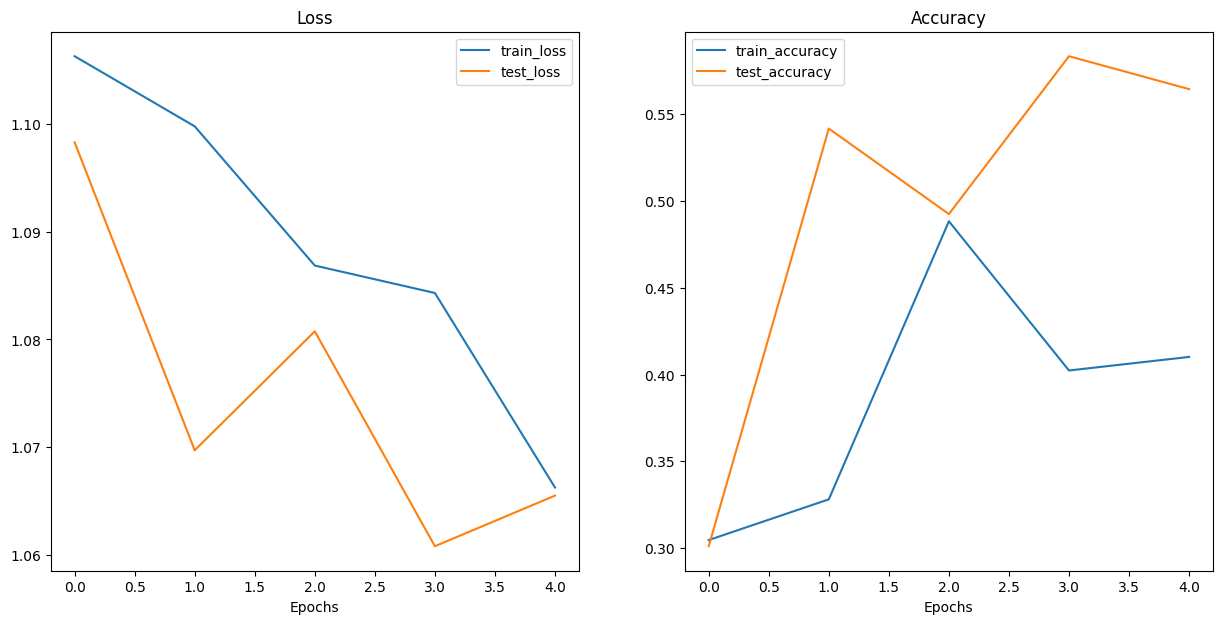

In [58]:
plot_loss_curves(results=model_0_results)

Even though the loss and accuracy values are not the ones we are looking for, we can see that the main trend of the values is indeed good. We want the loss to go down and the accuracy to improve.

* **Question:** can we improve these results by increasing the epochs?

  * **Answer:** in this case, no. Let's say we set the number of epochs to `30`. Then the train loss goes further down *but* the test_loss remains almost the same for every epoch. Why that might be? I think this might be a sign of *overfitting*. The model gets extremely used to the same little training data and is not able to perform well on unknown data (a.k.a test data).

## 8. What should an ideal loss curve look like?

![Loss Curves](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-loss-curves-overfitting-underfitting-ideal.jpg)

More about it in [Interpreting Loss Curves](https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic).

Dealing with **overfitting**:
* Get more data
* Data augmentation
* Better data
* Use transfer learning - Use and adjust weights and biases from pre-trained models into your data
* Simplify your model - Taking away layers, hidden units...
* Use learning rate decay - Learning rate defines how much the optimizer updates the parameters, so we can set it to decay over time (learning rate scheduling, at `torch.optim.lr_scheduler`)
* Use early stopping - Terminate the training before the testing error starts going up

Dealing with **underfitting**:
* Train for longer
* Add more layers/units
* Tweak the learning rate
* Use transfer learning
* Use less regularization - Too much preventing overfitting may cause your model to be held back

## 9. Model 1: TinyVGG with data augmentation

Now let's try another modelling experiment, using the same model as before but including Data Augmentation.

### 9.1 Create transform with data augmentation

In [59]:
# Create training transform with TrivialAugment
from torchvision import transforms

train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

### 9.2 Create train and test datasets and dataloaders with Data Augmentation

In [60]:
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transform_simple)

In [61]:
import os

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)

train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False,
                                        num_workers=NUM_WORKERS)

### 9.3 Construct and train Model 1

In [62]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)
).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [63]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

In [64]:
from timeit import default_timer as timer
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

start_time = timer()

model_1_results = train(
    model=model_1,
    train_dataloader=train_dataloader_augmented,
    test_dataloader=test_dataloader_simple,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=NUM_EPOCHS,
    device=device
)

end_time = timer()
print(f"Total training time for model_1: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1049 | Train acc: 0.2500 | Test loss: 1.1019 | Test acc: 0.2604
Epoch: 1 | Train loss: 1.0807 | Train acc: 0.4258 | Test loss: 1.1260 | Test acc: 0.2604
Epoch: 2 | Train loss: 1.0713 | Train acc: 0.4258 | Test loss: 1.1593 | Test acc: 0.2604
Epoch: 3 | Train loss: 1.1259 | Train acc: 0.3047 | Test loss: 1.1583 | Test acc: 0.2604
Epoch: 4 | Train loss: 1.0859 | Train acc: 0.4219 | Test loss: 1.1552 | Test acc: 0.3125
Total training time for model_1: 8.787 seconds


In [65]:
model_1_results

,epoch,train_loss,train_acc,test_loss,test_acc
0,0.0,1.104914,0.250000,1.101927,0.260417
1,1.0,1.080685,0.425781,1.126026,0.260417
2,2.0,1.071287,0.425781,1.159337,0.260417
3,3.0,1.125862,0.304688,1.158267,0.260417
4,4.0,1.085930,0.421875,1.155228,0.312500


### 9.4 Plot loss curves of Model 1

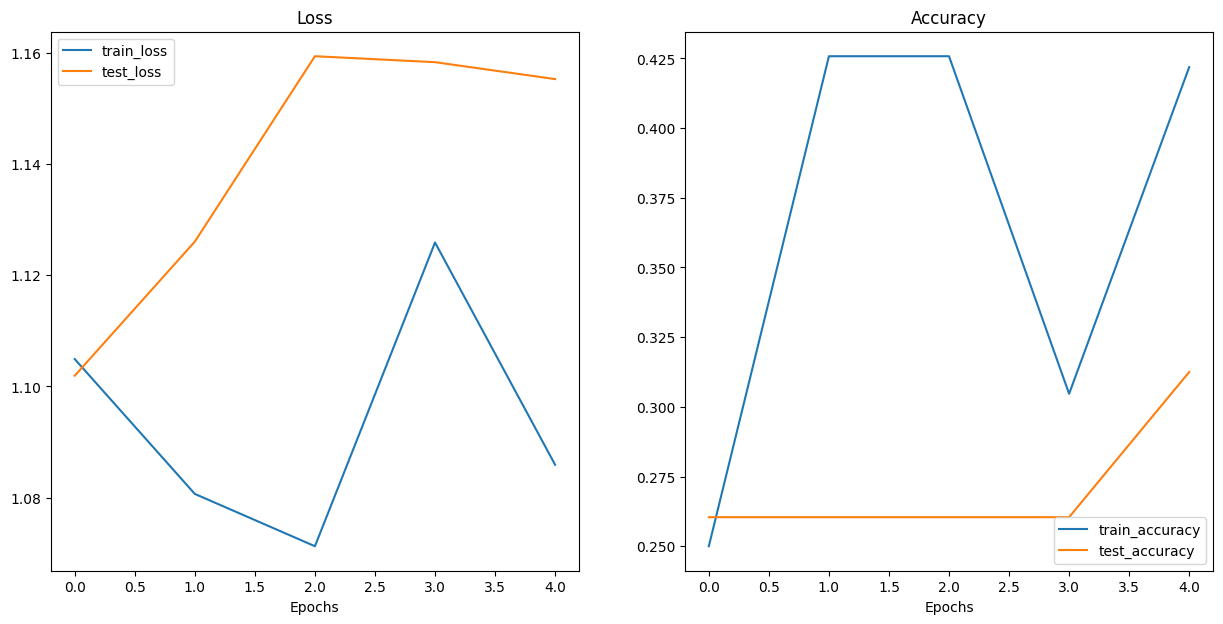

In [66]:
plot_loss_curves(model_1_results)

## 10. Compare model results

After comparing each model experiment on its own, it's important to compare them to one another.

Ways to do this:
* Hard code - code it yourself style
* Use [TensorBoard](https://pytorch.org/docs/stable/tensorboard.html)
* Use [Weights & Biases](https://wandb.ai/site/experiment-tracking)
* Use [MLFlow](https://mlflow.org/docs/latest/index.html)

In [67]:
# Convert the metric name
def convert_metric_name(metric_name: str) -> str:
  """
  Converts a metric name to a format with spaces and capitalized first letters.

  Args:
      metric_name: A string representing the metric name (e.g., "test_loss").

  Returns:
      A string representing the metric name in a better format (e.g., "Test Loss").
  """
  words = metric_name.split('_')  # Split the string by underscores
  words = [word.capitalize() for word in words]  # Capitalize each word with a list comprehension
  return ' '.join(words)  # Join the words back with spaces

In [68]:
# Create plot all function
def plot_results_comparison(**kwargs: pd.DataFrame):
  """
  Plots a comparison of all models' results, including train/test loss and accuracy,
  given that they trained for the same number of epochs.

  Args:
      **kwargs: Named arguments where keys are model names and values are pandas DataFrames
                 containing training and testing data. Each DataFrame is expected to have
                 columns named "train_loss", "test_loss", "train_acc", and "test_acc".
  """

  plt.figure(figsize=(15, 10))
  metrics = ["train_loss", "test_loss", "train_acc", "test_acc"]
  epochs  = range(len(next(iter(kwargs.values()))))

  for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    for model_name, df in kwargs.items():
      plt.plot(epochs, df[metric], label=model_name)
    plt.title(convert_metric_name(metric))
    plt.xlabel("Epochs")
    plt.legend()

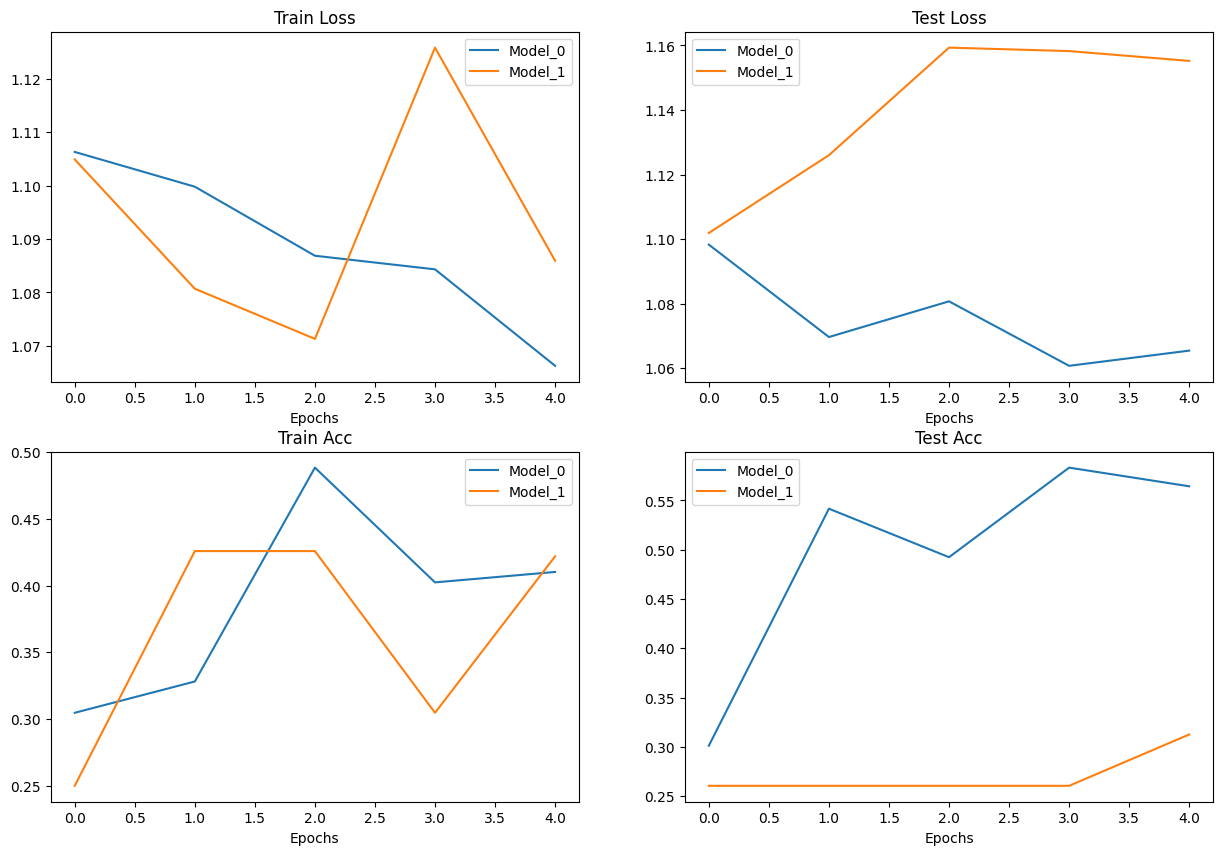

In [69]:
plot_results_comparison(Model_0=model_0_results, Model_1=model_1_results)

## 11. Making a prediction on a custom image

We used both training and testing data, but let's see how to make a prediction on a new image that is in neither both of those.

In [70]:
import torch
import torchvision

# Download custom image
import requests
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
data_path.mkdir(exist_ok=True)

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

### 11.1 Loading a custom image with PyTorch

We have to make sure our custom image is in the same format as the data our model trained on.
* In tensor form with the correct `datatype`
* Correct `shape`
* Correct `device`

In [71]:
import torchvision

# Load the image file
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

print(f"Custom image tensor: {custom_image_uint8}")
print(f"Custom image shape: {custom_image_uint8.shape}")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor: tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 4032, 3024])
Custom image dtype

### 11.2 Making a prediction on a custom image with a trained PyTorch model

In [72]:
# Trying to predict on an image in uint8 format
model_1.eval()
with torch.inference_mode():
  model_1(custom_image_uint8.to(device))

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [73]:
# Load in the custom image and convert to torch.float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float)

print(f"Custom image tensor: {custom_image}")
print(f"Custom image shape: {custom_image.shape}")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor: tensor([[[154., 173., 181.,  ...,  21.,  18.,  14.],
         [146., 165., 181.,  ...,  21.,  18.,  15.],
         [124., 146., 172.,  ...,  18.,  17.,  15.],
         ...,
         [ 72.,  59.,  45.,  ..., 152., 150., 148.],
         [ 64.,  55.,  41.,  ..., 150., 147., 144.],
         [ 64.,  60.,  46.,  ..., 149., 146., 143.]],

        [[171., 190., 193.,  ...,  22.,  19.,  15.],
         [163., 182., 193.,  ...,  22.,  19.,  16.],
         [141., 163., 184.,  ...,  19.,  18.,  16.],
         ...,
         [ 55.,  42.,  28.,  ..., 107., 104., 103.],
         [ 47.,  38.,  24.,  ..., 108., 104., 102.],
         [ 47.,  43.,  29.,  ..., 107., 104., 101.]],

        [[119., 138., 147.,  ...,  17.,  14.,  10.],
         [111., 130., 145.,  ...,  17.,  14.,  11.],
         [ 87., 111., 136.,  ...,  14.,  13.,  11.],
         ...,
         [ 35.,  22.,   8.,  ...,  52.,  52.,  48.],
         [ 27.,  18.,   4.,  ...,  50.,  49.,  44.],
         [ 27.,  23.,   9.,  ...

In [74]:
# Trying to predict on an image with the wrong shape
model_1.eval()
with torch.inference_mode():
  model_1(custom_image.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x756765 and 1690x3)

> **Note:** `read_image()` returns a tensor where each value is `[0, 255]`, so we can divide the tensor by that same number.

In [75]:
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float) / 255.
custom_image

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

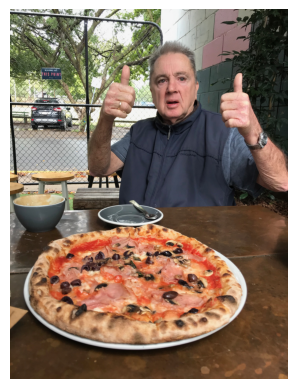

In [76]:
plt.imshow(custom_image.permute(1, 2, 0))
plt.axis(False);

In [77]:
# Create transform to resize the image
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64, 64))
])

# Transform custom image
custom_image_transformed = custom_image_transform(custom_image)

# Print results
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])


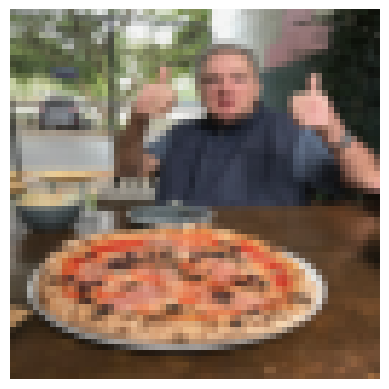

In [78]:
plt.imshow(custom_image_transformed.permute(1, 2, 0))
plt.axis(False);

In [79]:
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device)) # Add batch size

print(custom_image_pred)

tensor([[ 0.0816,  0.0340, -0.2070]], device='cuda:0')


In [80]:
# Convert logits -> prediction probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.3700, 0.3528, 0.2772]], device='cuda:0')

In [81]:
# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
custom_image_pred_label

tensor([0], device='cuda:0')

In [82]:
class_names[custom_image_pred_label]

'pizza'

### 11.3 Putting custom image prediction together into a function

Ideal outcome:

A function where we pass an image path and have our model make a prediction and plot the image and the prediction.

In [83]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device="cpu"):

  # Load the image
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float)

  # Divide the image pixel values by 255 to get between [0, 1]
  target_image = target_image / 255.

  # transform if necessary
  if transform:
    target_image = transform(target_image)

  # Check device-agnostic
  model = model.to(device)

  # Turn on eval/inference mode and make prediction
  model.eval()
  with torch.inference_mode():
    # Add  batch dimension
    target_image = target_image.unsqueeze(0)

    # make prediction
    target_image_pred = model(target_image.to(device))

  # Convert logits -> pred probs
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # Convert pred probs -> pred labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # Plot
  plt.imshow(target_image.squeeze().permute(1, 2, 0))
  if class_names:
    title = f"pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  else:
    title = f"pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"

  plt.title(title)
  plt.axis(False)

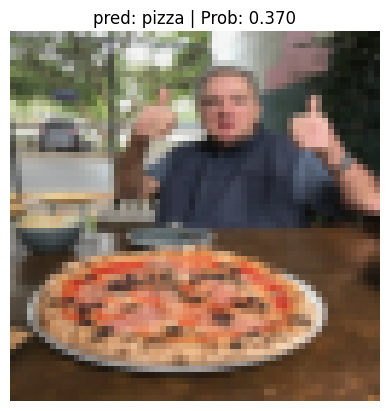

In [84]:
pred_and_plot_image(
    model=model_1,
    image_path=custom_image_path,
    class_names=class_names,
    transform=custom_image_transform,
    device=device
)

## Exercises

[Source](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/04_pytorch_custom_datasets.ipynb)

2. Recreate the data loading functions we built in sections 1, 2, 3 and 4. You should have train and test `DataLoader`'s ready to use.

In [85]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [86]:
from pathlib import Path
import zipfile
import requests

data_path = Path("data/")
dataset_path = data_path / "pizza_steak_sushi_ex"

if dataset_path.is_dir():
  print(f"{dataset_path} already exists.")
else:
  print(f"Creating {dataset_path}...")
  dataset_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi_ex.zip", "wb") as f:
  print("Downloading data...")
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  f.write(request.content)

with zipfile.ZipFile(data_path / "pizza_steak_sushi_ex.zip", "r") as zip_file:
  print("Extracting data...")
  zip_file.extractall(dataset_path)

Creating data/pizza_steak_sushi_ex...
Extracting data...


In [87]:
from torchvision import transforms

ex_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

ex_transform

Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [88]:
from torchvision.datasets import ImageFolder

train_dir = dataset_path / "train"
test_dir = dataset_path / "test"

train_dataset = ImageFolder(root=train_dir,
                            transform=ex_transform,
                            target_transform=None)

test_dataset = ImageFolder(root=test_dir,
                           transform=ex_transform)

train_dataset, test_dataset

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi_ex/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi_ex/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [89]:
sample_img = train_dataset[0][0]
sample_label = train_dataset[0][1]

sample_img.shape

torch.Size([3, 64, 64])

In [90]:
class_names = train_dataset.classes

class_names

['pizza', 'steak', 'sushi']

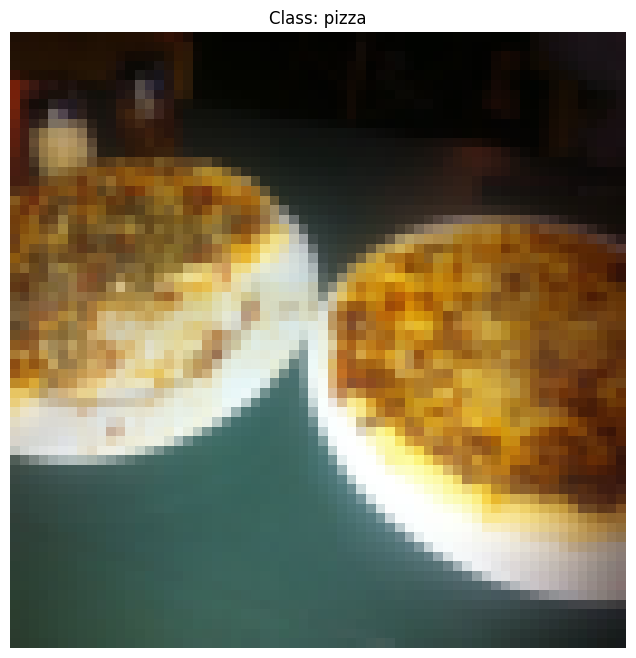

In [91]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.title(f"Class: {class_names[sample_label]}")
plt.axis(False)
plt.imshow(sample_img.permute([1, 2, 0]));

In [92]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=1
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=1
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x77fb3a43d330>,
 <torch.utils.data.dataloader.DataLoader at 0x77fb3a43ead0>)

3. Recreate `model_0` we built in section 7.

In [93]:
from torch import nn

class TinyVGG_ex(nn.Module):

  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(
            in_channels=input_shape,
            out_channels=hidden_units,
            kernel_size=(3, 3),
            stride=1,
            padding=0
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=(3, 3),
            stride=1,
            padding=0
        ),
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size=(2, 2),
            stride=2
        )
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=(3, 3),
            stride=1,
            padding=0
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=(3, 3),
            stride=1,
            padding=0
        ),
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size=(2, 2),
            stride=2
        )
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(
            in_features=hidden_units * 13 * 13,
            out_features=output_shape
        )
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [94]:
model_ex = TinyVGG_ex(
    input_shape=3,
    hidden_units=10,
    output_shape=len(class_names)
)

model_ex

TinyVGG_ex(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [95]:
try:
  from torchinfo import summary
except:
  print("Installing torchinfo...")
  !pip install torchinfo
  from torchinfo import summary

In [96]:
summary(
    model=model_ex,
    input_size=(BATCH_SIZE, 3, 64, 64)
)

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG_ex                               [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

4. Create training and testing functions for `model_0`.

In [97]:
from typing import Tuple

In [98]:
def train_step_ex(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn,
               optimizer: torch.optim,
               device = "cpu") -> Tuple[int, int]:

  model = model.to(device)

  train_loss, train_acc = 0, 0

  model.train()

  for batch, (X, y) in enumerate(data_loader):

    X, y = X.to(device), y.to(device)

    y_logits = model(X)

    loss = loss_fn(y_logits, y)
    train_loss += loss.item()
    y_preds = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
    train_acc += (y_preds == y).sum().item() / len(y)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)

  return train_loss, train_acc

In [99]:
def test_step_ex(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn,
              device = "cpu") -> Tuple[int, int]:

  model = model.to(device)

  test_loss, test_acc = 0, 0

  model.eval()

  with torch.inference_mode():
    for batch, (X, y) in enumerate(data_loader):

      X, y = X.to(device), y.to(device)

      y_logits = model(X)

      loss = loss_fn(y_logits, y)
      test_loss += loss.item()
      y_preds = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
      test_acc += (y_preds == y).sum().item() / len(y)

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

  return test_loss, test_acc

In [100]:
from tqdm.auto import tqdm
import pandas as pd

def train_ex(model: torch.nn.Module,
          train_data_loader: torch.utils.data.DataLoader,
          test_data_loader: torch.utils.data.DataLoader,
          loss_fn: torch.nn,
          optimizer: torch.optim,
          device = "cpu",
          epochs: int = 3,
          console_ratio: int = 0) -> pd.DataFrame:

  result = pd.DataFrame(data={"epoch": [], "train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []})

  console_ratio = max(0, min(console_ratio, 1))

  for epoch in tqdm(range(epochs)):

    console_out = console_ratio > 0 and epoch % (1 / console_ratio) == 0

    if console_out:
      print(f"-----------\nEpoch {epoch}")

    train_loss, train_acc = train_step_ex(
        model=model,
        data_loader=train_data_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        device=device
    )

    test_loss, test_acc = test_step_ex(
        model=model,
        data_loader=test_data_loader,
        loss_fn=loss_fn,
        device=device
    )

    result.loc[len(result.index)] = [epoch, train_loss, train_acc, test_loss, test_acc]

    if console_out:
      print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}\nTest loss: {test_loss:.5f} | Test acc: {test_acc:.2f}")

  return result

5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
  * Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer.

In [101]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model_ex.parameters(), lr=0.001)

In [102]:
results_epochs_5 = train_ex(
    model=model_ex,
    train_data_loader=train_dataloader,
    test_data_loader=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device,
    epochs=5,
    console_ratio=1
)

  0%|          | 0/5 [00:00<?, ?it/s]

-----------
Epoch 0
Train loss: 1.10693 | Train acc: 0.23
Test loss: 1.11772 | Test acc: 0.26
-----------
Epoch 1
Train loss: 1.08570 | Train acc: 0.43
Test loss: 1.12332 | Test acc: 0.26
-----------
Epoch 2
Train loss: 1.11333 | Train acc: 0.30
Test loss: 1.12953 | Test acc: 0.26
-----------
Epoch 3
Train loss: 1.11594 | Train acc: 0.30
Test loss: 1.12698 | Test acc: 0.26
-----------
Epoch 4
Train loss: 1.10052 | Train acc: 0.30
Test loss: 1.10427 | Test acc: 0.26


In [103]:
results_epochs_20 = train_ex(
    model=model_ex,
    train_data_loader=train_dataloader,
    test_data_loader=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device,
    epochs=20,
    console_ratio=0.25
)

  0%|          | 0/20 [00:00<?, ?it/s]

-----------
Epoch 0
Train loss: 1.09840 | Train acc: 0.28
Test loss: 1.08772 | Test acc: 0.54
-----------
Epoch 4
Train loss: 1.05055 | Train acc: 0.44
Test loss: 1.04233 | Test acc: 0.59
-----------
Epoch 8
Train loss: 0.92492 | Train acc: 0.50
Test loss: 1.05530 | Test acc: 0.39
-----------
Epoch 12
Train loss: 0.93205 | Train acc: 0.56
Test loss: 1.05045 | Test acc: 0.36
-----------
Epoch 16
Train loss: 0.79142 | Train acc: 0.71
Test loss: 0.99765 | Test acc: 0.48


In [104]:
results_epochs_50 = train_ex(
    model=model_ex,
    train_data_loader=train_dataloader,
    test_data_loader=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device,
    epochs=50,
    console_ratio=0.1
)

  0%|          | 0/50 [00:00<?, ?it/s]

-----------
Epoch 0
Train loss: 0.73266 | Train acc: 0.70
Test loss: 1.05005 | Test acc: 0.45
-----------
Epoch 10
Train loss: 0.49436 | Train acc: 0.80
Test loss: 1.36016 | Test acc: 0.43
-----------
Epoch 20
Train loss: 0.27875 | Train acc: 0.89
Test loss: 1.40525 | Test acc: 0.46
-----------
Epoch 30
Train loss: 0.10018 | Train acc: 0.98
Test loss: 1.87603 | Test acc: 0.51
-----------
Epoch 40
Train loss: 0.05887 | Train acc: 0.98
Test loss: 2.87465 | Test acc: 0.43


In [105]:
results_epochs_5

,epoch,train_loss,train_acc,test_loss,test_acc
0,0.0,1.106928,0.234375,1.117723,0.260417
1,1.0,1.085699,0.425781,1.123322,0.260417
2,2.0,1.113326,0.304688,1.129534,0.260417
3,3.0,1.115940,0.304688,1.126983,0.260417
4,4.0,1.100522,0.304688,1.104273,0.260417


In [106]:
results_epochs_20

,epoch,train_loss,train_acc,test_loss,test_acc
0,0.0,1.098397,0.277344,1.087715,0.541667
1,1.0,1.093956,0.375000,1.091907,0.442235
2,2.0,1.090867,0.414062,1.078485,0.584280
3,3.0,1.076069,0.441406,1.075720,0.534091
4,4.0,1.050553,0.437500,1.042332,0.594697
5,5.0,1.049804,0.433594,0.983735,0.583333
6,6.0,0.911198,0.640625,0.991475,0.422348
7,7.0,0.860701,0.636719,1.016236,0.453598
8,8.0,0.924920,0.503906,1.055303,0.392045
9,9.0,0.893942,0.695312,1.044426,0.402462


In [107]:
results_epochs_50

,epoch,train_loss,train_acc,test_loss,test_acc
0,0.0,0.732655,0.703125,1.050049,0.454545
1,1.0,0.763443,0.714844,1.058509,0.372159
2,2.0,0.746905,0.683594,1.042893,0.392992
3,3.0,0.654367,0.718750,1.050811,0.444129
4,4.0,0.616050,0.757812,1.089767,0.412879
5,5.0,0.599868,0.750000,1.135989,0.392992
6,6.0,0.537959,0.785156,1.070902,0.484848
7,7.0,0.512096,0.816406,1.008362,0.566288
8,8.0,0.537969,0.804688,1.195550,0.363636
9,9.0,0.551662,0.671875,1.141228,0.455492


6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [108]:
model_ex_v2 = TinyVGG_ex(
    input_shape=3,
    hidden_units=20,
    output_shape=len(class_names)
)

model_ex_v2

TinyVGG_ex(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3380, out_features=3, bias=True)
  )
)

In [109]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model_ex_v2.parameters(), lr=0.001)

In [110]:
results_model_ex_v2 = train_ex(
    model=model_ex_v2,
    train_data_loader=train_dataloader,
    test_data_loader=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device,
    epochs=20,
    console_ratio=0.25
)

  0%|          | 0/20 [00:00<?, ?it/s]

-----------
Epoch 0
Train loss: 1.09200 | Train acc: 0.32
Test loss: 1.11668 | Test acc: 0.24
-----------
Epoch 4
Train loss: 0.98989 | Train acc: 0.43
Test loss: 1.01255 | Test acc: 0.54
-----------
Epoch 8
Train loss: 0.94210 | Train acc: 0.54
Test loss: 1.09520 | Test acc: 0.37
-----------
Epoch 12
Train loss: 0.84476 | Train acc: 0.59
Test loss: 1.01893 | Test acc: 0.44
-----------
Epoch 16
Train loss: 0.84181 | Train acc: 0.47
Test loss: 0.96359 | Test acc: 0.57


In [111]:
results_model_ex_v2

,epoch,train_loss,train_acc,test_loss,test_acc
0,0.0,1.091998,0.316406,1.116683,0.239583
1,1.0,1.073229,0.441406,1.092865,0.343750
2,2.0,0.972305,0.566406,1.102950,0.290720
3,3.0,0.963368,0.460938,0.932579,0.593750
4,4.0,0.989891,0.425781,1.012546,0.544508
5,5.0,0.867756,0.621094,1.152373,0.302083
6,6.0,0.924680,0.488281,1.072993,0.392992
7,7.0,0.827893,0.664062,0.956278,0.494318
8,8.0,0.942095,0.542969,1.095198,0.372159
9,9.0,0.888612,0.500000,1.037259,0.423295


7. Double the data you're using with your model and train it for 20 epochs, what happens to the results?
  * **Note:** You can use the custom data creation notebook to scale up your Food101 dataset.
  * You can also find the already formatted double data (20% instead of 10% subset) dataset on GitHub, you will need to write download code like in exercise 2 to get it into this notebook.

In [112]:
data_path = Path("data/")
dataset_path = data_path / "pizza_steak_sushi_20_percent"

if dataset_path.is_dir():
  print(f"{dataset_path} already exists.")
else:
  dataset_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
  print("Downloading...")
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
  f.write(request.content)

with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_file:
  print("Extracting...")
  zip_file.extractall(dataset_path)

Downloading...
Extracting...


In [113]:
train_dir = dataset_path / "train"
test_dir = dataset_path / "test"

train_dataset_20 = ImageFolder(root=train_dir,
                            transform=ex_transform,
                            target_transform=None)

test_dataset_20 = ImageFolder(root=test_dir,
                           transform=ex_transform)

train_dataset_20, test_dataset_20

(Dataset ImageFolder
     Number of datapoints: 450
     Root location: data/pizza_steak_sushi_20_percent/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 150
     Root location: data/pizza_steak_sushi_20_percent/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [114]:
BATCH_SIZE = 32

train_dataloader_20 = DataLoader(
    dataset=train_dataset_20,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=1
)

test_dataloader_20 = DataLoader(
    dataset=test_dataset_20,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=1
)

train_dataloader_20, test_dataloader_20

(<torch.utils.data.dataloader.DataLoader at 0x77fb3a61ccd0>,
 <torch.utils.data.dataloader.DataLoader at 0x77fb892e16c0>)

In [115]:
model_ex_20 = TinyVGG_ex(
    input_shape=3,
    hidden_units=20,
    output_shape=len(class_names)
)

model_ex_20

TinyVGG_ex(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3380, out_features=3, bias=True)
  )
)

In [116]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model_ex_20.parameters(), lr=0.001)

In [117]:
results_model_ex_20 = train_ex(
    model=model_ex_20,
    train_data_loader=train_dataloader_20,
    test_data_loader=test_dataloader_20,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device,
    epochs=20,
    console_ratio=0.2
)

  0%|          | 0/20 [00:00<?, ?it/s]

-----------
Epoch 0
Train loss: 1.09096 | Train acc: 0.36
Test loss: 1.05887 | Test acc: 0.45
-----------
Epoch 5
Train loss: 0.89286 | Train acc: 0.59
Test loss: 0.89430 | Test acc: 0.61
-----------
Epoch 10
Train loss: 0.73367 | Train acc: 0.68
Test loss: 0.83396 | Test acc: 0.60
-----------
Epoch 15
Train loss: 0.61555 | Train acc: 0.73
Test loss: 0.91055 | Test acc: 0.55


In [118]:
results_model_ex_20

,epoch,train_loss,train_acc,test_loss,test_acc
0,0.0,1.090960,0.358333,1.058868,0.448864
1,1.0,0.977376,0.510417,0.993545,0.434091
2,2.0,0.879361,0.566667,0.960447,0.569886
3,3.0,0.883096,0.622917,0.909079,0.588068
4,4.0,0.919496,0.604167,0.925940,0.541477
5,5.0,0.892856,0.593750,0.894301,0.606818
6,6.0,0.844422,0.606250,0.917639,0.591477
7,7.0,0.873216,0.572917,0.901654,0.613068
8,8.0,0.816820,0.633333,0.913405,0.552841
9,9.0,0.775406,0.691667,0.969895,0.569886


8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) and share your prediction.
  * Does the model you trained in exercise 7 get it right?
  * If not, what do you think you could do to improve it?

In [119]:
import requests

sushi_img_path = data_path / "sushi.jpg"

if not sushi_img_path.is_file():
  print("Downloading image...")
  with open(sushi_img_path, "wb") as f:
    request = requests.get("https://static.wixstatic.com/media/f5aeb3_ee55aae5014449649e6dbb3adb4dc22b~mv2.jpeg/v1/fill/w_640,h_426,al_c,q_80,usm_0.66_1.00_0.01,enc_auto/f5aeb3_ee55aae5014449649e6dbb3adb4dc22b~mv2.jpeg")
    f.write(request.content)
else:
  print("Image has already been downloaded.")

In [120]:
custom_img = torchvision.io.read_image(str(sushi_img_path)).type(torch.float)

custom_img.dtype, custom_img.shape # We make sure that the dtype and shape are correct

(torch.float32, torch.Size([3, 426, 640]))

In [121]:
custom_img /= 255 # Convert values to range [0, 1]

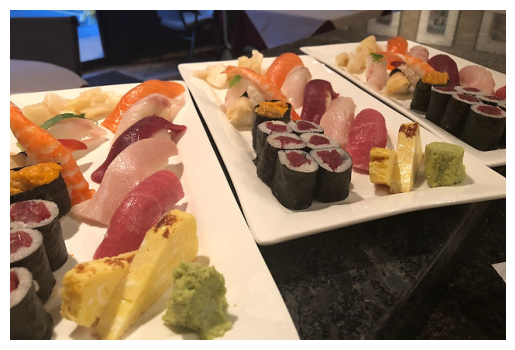

In [122]:
# Visualize it
import matplotlib.pyplot as plt

plt.imshow(custom_img.permute(1, 2, 0))
plt.axis(False);

In [123]:
custom_transform = transforms.Compose([
    transforms.Resize(size=(64, 64))
])

In [124]:
custom_img_transformed = custom_transform(custom_img)

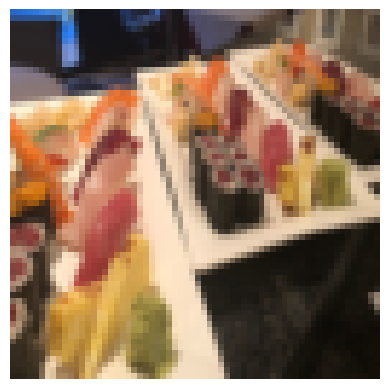

In [125]:
# Visualize it
plt.imshow(custom_img_transformed.permute(1, 2, 0))
plt.axis(False);

In [126]:
model_ex_20 = model_ex_20.to(device)

model_ex_20.eval()
with torch.inference_mode():
  y_logits = model_ex_20(custom_img_transformed.unsqueeze(0).to(device))
  y_pred = (y_logits.softmax(dim=1)).argmax(dim=1)

pred_class = class_names[y_pred]
pred_class

'sushi'